# Text Mining


In [2]:
import multiprocessing

import nltk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.lm import MLE
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')  # omw = open multilingual wordnet
stopword_list = set(stopwords.words('english'))
reg_tokenizer = nltk.RegexpTokenizer(r"\w+")  # tokenizes and removes punctuation at the same time
wordnet_lemmatizer = WordNetLemmatizer();

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Data Loading and Preprocessing

## (a)

,text,label
0,i would think that whomever would be lucky eno...,Love
1,i fear that they won t ever feel that deliciou...,Joy
2,im forever taking some time out to have a lie ...,Surprise
3,i try to be nice though so if you get a bitchy...,Joy
4,i have officially graduated im not feeling as ...,Joy


,text,label
count,247910,247910
unique,236060,4
top,i feel more adventurous willing to take risks,Joy
freq,16,141067


<Axes: xlabel='label', ylabel='count'>

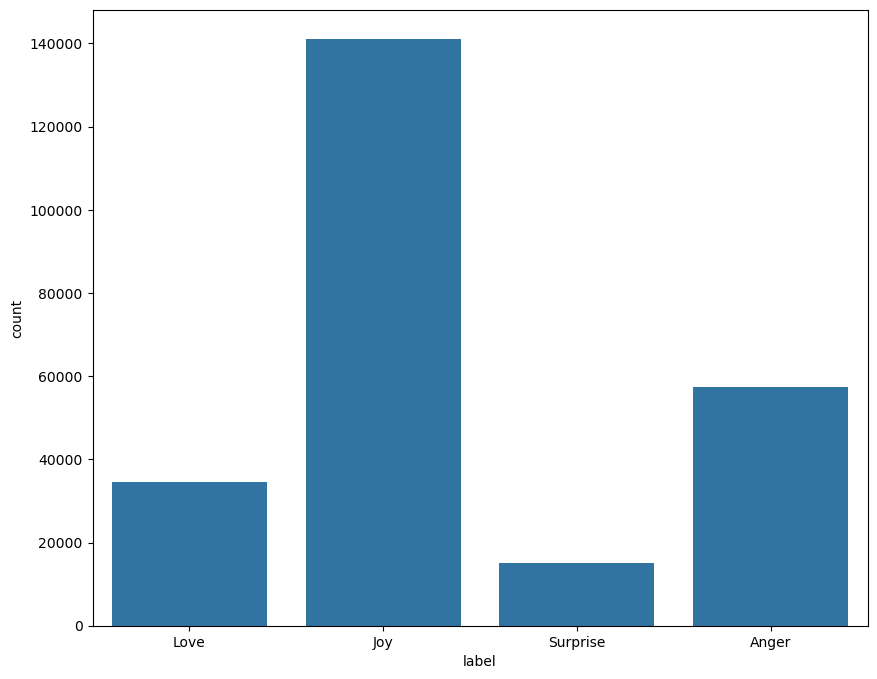

In [3]:
df = pd.read_csv("text_mining/emotions.csv")

display(df.head())
display(df.describe())
plt.figure(figsize=(10,8))
sns.countplot(x="label", data=df)

## (b)

(59888, 2)


,text,label
0,i feel like a jerk because the library student...,Anger
1,i miss all the others as well that feel that i...,Anger
2,i saunter through the airport terminals feelin...,Anger
3,i need to feel dangerous and pretty so here a ...,Anger
4,when,Anger


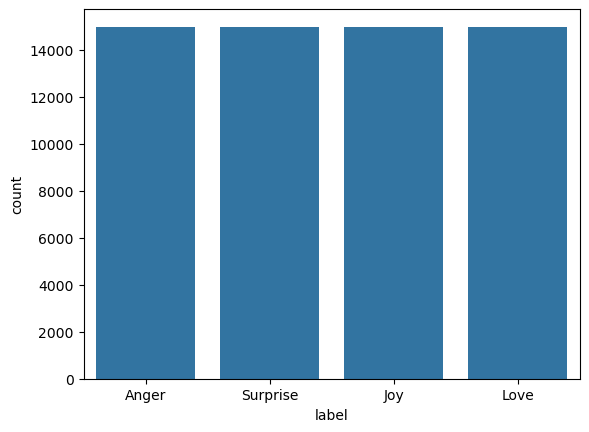

In [4]:
# under sampling by taking the k first entrys from each 

labels = df["label"].unique()
min_label = min([len(df[df["label"]==label]) for label in labels])
#instantiate df for concat
df_balanced = pd.DataFrame([],columns=["text","label"])

for label in labels:
    df_balanced = pd.concat([df[df["label"] == label][:min_label],df_balanced],ignore_index=True)


print(np.shape(df_balanced))
display(df_balanced.head())
# verification
sns.countplot(x="label", data=df_balanced)
df = df_balanced


## (c)

In [5]:
def preprocessing(df: pd.DataFrame)-> list:
    corpus = df["text"]
    doc_list =[]
    for i in range(len(corpus)):
        text = corpus[i]
        tokenized = reg_tokenizer.tokenize(text)
        filtered = [word.lower() for word in tokenized if word.lower() not in stopword_list]
        # print(len(text)-len(filtered))
        lemmatized  = [wordnet_lemmatizer.lemmatize(word) for word in filtered]
        doc = " ".join(lemmatized)
        doc_list.append(doc)
    df_out = pd.DataFrame({"document":doc_list,"label": list(df["label"])})
    return df_out
# calc the difference in length for between un-/preprocessed
def count_tokens(documents) -> int:
    return documents.apply(lambda text: len(text.split(" "))).sum()

processed_df = preprocessing(df)
count_before = count_tokens(df["text"])
count_after = count_tokens(processed_df["document"])
print(f"Number of tokens before processing: {count_before}")
print(f"Number of tokens after processing: {count_after}")
print(f"Difference in tokens after processing: {count_before - count_after}")


Number of tokens before processing: 1187786
Number of tokens after processing: 575839
Difference in tokens after processing: 611947


In [6]:
def split_data(df: pd.DataFrame):
    return train_test_split(df, random_state=12345, train_size=0.8, stratify=df['label'])

train, test = split_data(df)
for data in (train, test):
    for i in range(3):
        print(data.iloc[i]["text"])

my parents came to visit me
ill state that i am angry at myself for feeling so out of control and so hostile
i feel calm complete and whole after i meditate
i feel blessed each day with what i have been given and i understand that these are first world problems i have a roof over my head ample food and freedom and yet
i feel like a loser because all the guys i have liked so far aren t ready for a relationship what do i do
i had a funny feeling when i accepted them


## Bag-of-Words

In [7]:
def preprocess_classifier(df: pd.DataFrame):
    processed_df = preprocessing(df)
    train, test = split_data(processed_df)
    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(train['document'])
    y_train = train["label"]
    X_test = vectorizer.transform(test['document'])
    y_test = test["label"]
    return X_train, y_train, X_test, y_test, vectorizer

X_train, y_train, X_test, y_test, vectorizer = preprocess_classifier(df)

def train_classifier(X_train, y_train):
    sgd = SGDClassifier(loss='log_loss', random_state=12345)
    sgd.fit(X_train, y_train)

    return sgd

classifier = train_classifier(X_train, y_train)

def accuracy_classifier(sgd, X_train, y_train, X_test, y_test):
    #Accuracy on train data:
    train_pred = sgd.predict(X_train)
    acc_train = accuracy_score(y_train, train_pred)
    print(f"Training accuracy: {acc_train:.3f}")
    #Accuracy on test data:
    test_pred = sgd.predict(X_test)
    acc_test = accuracy_score(y_test, test_pred)
    print(f"Test accuracy: {acc_test:.3f}")

accuracy_classifier(classifier, X_train, y_train, X_test, y_test)

Training accuracy: 0.967
Test accuracy: 0.953


## N-Grams

In [8]:
corpus = df["text"]
tokenized_corpus = [reg_tokenizer.tokenize(sentence.lower()) for sentence in corpus]

2-gram output:

Document: im heading to have fond of my victim i feel you have a pretty pleased with excitement but since i want to be surprised when a sincere in the only indirectl
Prediction: ['Surprise']


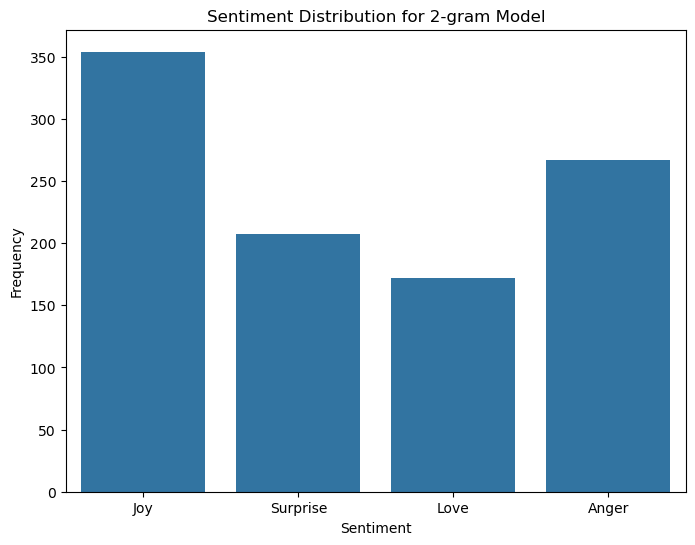

5-gram output:

Document: i just want to do everything i can to make you happy healthy feel loved and safe and cared for with my whole heart
Prediction: ['Love']


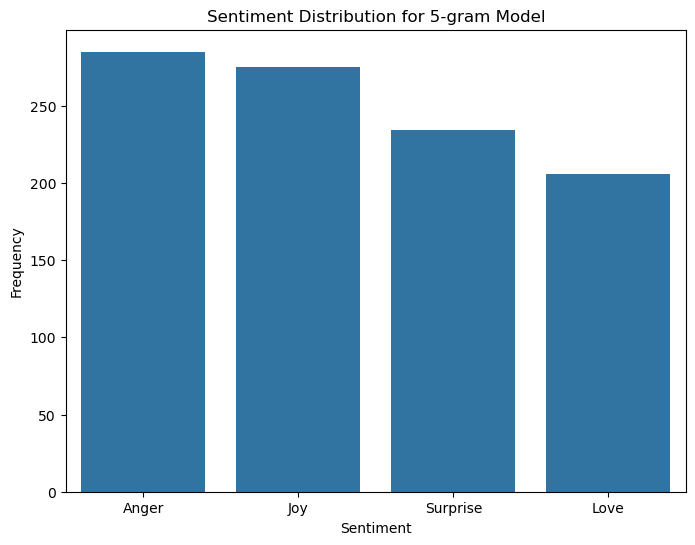

In [11]:


def train_MLE(corpus, n):
    
    train_data, vocab = padded_everygram_pipeline(n, corpus)

    mle_model = MLE(n)
    mle_model.fit(train_data, vocab)
    return mle_model

def generate_text(model, num_words, start_with=None):
    text = []
    context = start_with if start_with else ["<s>"]*(model.order -1)
    for _ in range(num_words):
        next_word = model.generate(1, text_seed=context)
        if next_word == "</s>":
            break
        text.append(next_word)
        context = context[1:] + [next_word]
    return " ".join(text)

for i in [2, 5]:
    model = train_MLE(tokenized_corpus, i)
        
    text_output = generate_text(model, 50)
    text_vectorized = vectorizer.transform([text_output])
    prediction = classifier.predict(text_vectorized)

    print(f"{i}-gram output:\n")    
    print(f"Document: {text_output}")
    print(f"Prediction: {prediction}")
    
    # 1000 documents
    number_docs = 1000
    generated_df = pd.DataFrame(columns=["text", "label"])
    for _ in range(number_docs):
        doc = generate_text(model, 50)
        text_vectorized = vectorizer.transform([doc])
        prediction = classifier.predict(text_vectorized)
        new_row = pd.DataFrame({"text": doc, "label": prediction})
        generated_df = pd.concat([generated_df, new_row])

    plt.figure(figsize=(8, 6))
    sns.countplot(x="label", data=generated_df)
    plt.title(f"Sentiment Distribution for {i}-gram Model")
    plt.xlabel('Sentiment')
    plt.ylabel('Frequency')
    plt.show()

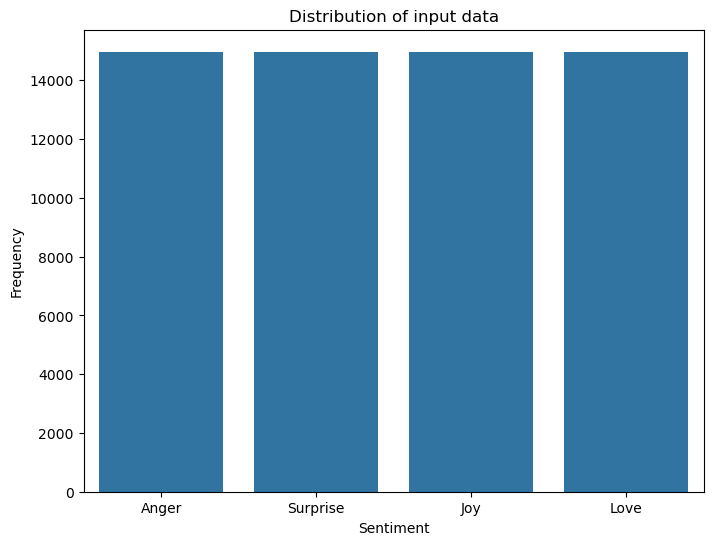

In [12]:
classifier

plt.figure(figsize=(8, 6))
sns.countplot(x="label", data=df)
plt.title(f"Distribution of input data")
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

In [9]:
# (g)
# Which distribution seems to be more balanced?
print("The distribution of the texts generated by the 5-gram model seem more balanced.")
# Why does n infleunce the distribution?
print("A higher n means, that the text generated uses more context and therefore is more similar to the provided input data. The 5-gram model is more balanced as the balanced input data implies.\nIt is interesting that the 2-gram seems to convey the previous 'eliminated' bias. This may be due to local patterns between tokens that were not removed.")

The distribution of the texts generated by the 5-gram model seem more balanced.
A higher n means, that the text generated uses more context and therefore is more similar to the provided input data. The 5-gram model is more balanced as the balanced input data implies.
It is interesting that the 2-gram seems to convey the previous 'eliminated' bias. This may be due to local patterns between tokens that were not removed.


## Word2Vec

In [10]:
workers = 1
word_2_vec_model = Word2Vec(sentences = tokenized_corpus, window = 5, min_count = 3, vector_size = 25, epochs = 50, sg = 1, workers = workers)

[ 0.16799831 -0.30248567  0.6052797  -0.26291886  0.31209213  1.0652536
 -0.00326563  0.5384331  -0.33353287 -0.579774   -0.17459035  0.18938932
 -0.27741784 -0.36188114 -0.8864588   0.7072021   0.42068863  0.98693836
 -0.6292437  -0.07630281  0.02646835  0.4586245   0.17464136  0.19724233
  0.44269168]


In [24]:
vector_christmas = word_2_vec_model.wv['christmas']

if 'christmas' in word_2_vec_model.wv:
    # Find top 3 most similar words
    most_similar = word_2_vec_model.wv.most_similar('christmas', topn=3)
    print("Most Similar Words to 'christmas':")
    for word, similarity in most_similar:
        print(f"{word}: {similarity:.3f}")

# Find the top 3 most disimilar words
keys = word_2_vec_model.wv.index_to_key
least_sim = []
for key in keys:
    cos_sim = word_2_vec_model.wv.similarity('christmas', key)
    info = (key, cos_sim)
    least_sim.append(info)
    if len(least_sim) > 3:
        least_sim.sort(key=lambda x: x[1])
        least_sim.pop()
print("The 3 most dissimilar words to 'christmas' are:\n")
for word, similarity in least_sim:
        print(f"{word}: {similarity:.3f}") 
# Can be solved easilier by using most_similar(negative=['christmas'])

Most Similar Words to 'christmas':
holiday: 0.867
thanksgiving: 0.866
halloween: 0.839
The 3 most dissimilar words to 'christmas' are:

harshly: -0.304
accusing: -0.281
wolf: -0.260


## (j)

In [ ]:
# The most similar word to chrismas has a similar vector (meaning they have a cos close to 1).
# This means that a dissimilar word to christmas (that has a cos closer to -1) also has a cosinus close to -1 with a vector similar to christmas.
# Therefore a similar vector to x is also dissimilar to a vector y that is dissimilar to x.

## (k)

In [34]:
print("Emotions related to christmas:\n")
print(word_2_vec_model.wv.most_similar(positive=['emotions', 'christmas'], negative=[], topn = 3))
print("Emotions unrelated to christmas:\n")
print(word_2_vec_model.wv.most_similar(positive=['emotions'], negative=['christmas'], topn = 3))

Emotions related to christmas:

[('thankfulness', 0.8362123370170593), ('lows', 0.8311241269111633), ('memories', 0.7954427599906921)]
Emotions unrelated to christmas:

[('anger', 0.7128562927246094), ('hatred', 0.7112752199172974), ('feelings', 0.7108699679374695)]


In [35]:
# Finding words that are emotions on chrismas are similar to emotions and christmas, therefore they are positive.
# Finding words that are emotions and most unrelated to christmas are similar to emotions and dissimilar to christmas, therefore emotions are positive and christmas is negative.

# the most_similar() function creates a mean of all vectors, where negative vectors are flipped around (or subtracted). Then it searches to vectors, most similar to this median vector.
# By flipping the negative vectors, they contribute negatively to the result, finding dissimilar keys.